In [444]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchinfo import summary
import torchvision.models as models

### 이미지 전처리 & Dataset 생성 & DataLoader 생성

In [445]:
preprocessing = transforms.Compose([
    transforms.Resize(size = (100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [446]:
file_dir = './data/kaggle_flickr30k_images/flickr30k_images'
imgDS = ImageFolder(file_dir, preprocessing)

In [447]:
print(imgDS.class_to_idx)

{'flickr30k_images': 0}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


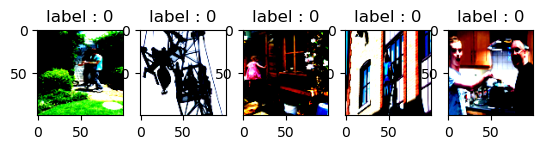

In [448]:
# 데이터셋 내 사진들 확인
k = 1
for (img, label) in imgDS:
    plt.subplot(1,5,k)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"label : {label}")
    k += 1
    if k == 6 : break
plt.show()

In [449]:
# dataset에서 train, valid, test를 나누기 
seed_gen = torch.Generator().manual_seed(42)
tr, val, ts = 0.7,0.1,0.2
trainDS, validDS, testDS = random_split(imgDS, [tr, val, ts], generator=seed_gen)
print(len(trainDS), len(validDS), len(testDS))

22249 3178 6356


In [450]:
# dataloader 생성
batch_size = 300
train_dl = DataLoader(trainDS, batch_size=batch_size, shuffle=True, drop_last = True)
valid_dl = DataLoader(validDS, batch_size=batch_size, shuffle=True, drop_last = True)
test_dl = DataLoader(testDS, batch_size = batch_size, shuffle=True, drop_last = True)
print(len(train_dl), len(valid_dl), len(test_dl))

74 10 21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


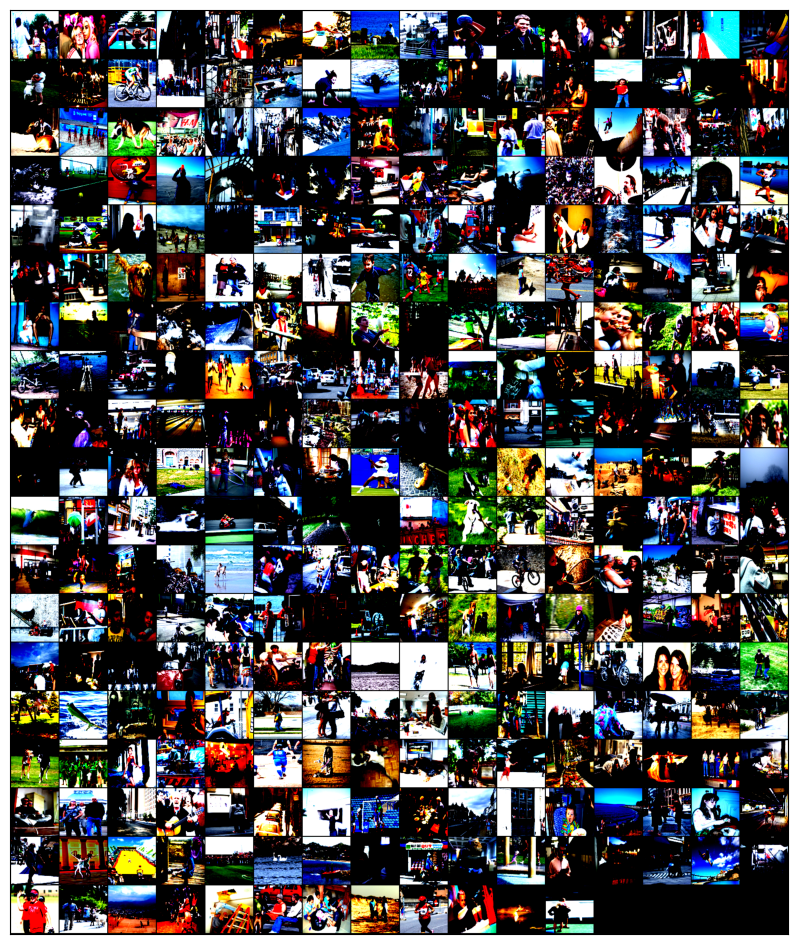

In [451]:
# 1개의 배치 안에 있는 이미지 확인
from torchvision.utils import make_grid

def show_batch(dl):
    """Plot images grid of single batch"""
    for (images, labels) in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

### RNN을 위한 전처리 및 단어사전 생성

In [452]:
file = pd.read_csv('./data/kaggle_flickr30k_images/results.csv', sep='|')
file.columns = ['image_name','comment_num','comment']
file.head(10)

image_name comment_num  \
0  1000092795.jpg           0   
1  1000092795.jpg           1   
2  1000092795.jpg           2   
3  1000092795.jpg           3   
4  1000092795.jpg           4   
5    10002456.jpg           0   
6    10002456.jpg           1   
7    10002456.jpg           2   
8    10002456.jpg           3   
9    10002456.jpg           4   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1   Two young , White males are outside near many...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  
5   Several men in hard hats are operating a gian...  
6   Workers look down from up above on a piece of...  
7   Two men working on a machine wearing hard hats .  
8              Four men on top of a tall structure .  
9                         Three men on a large rig .

In [453]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158915 entries, 0 to 158914
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   image_name   158915 non-null  object
 1   comment_num  158915 non-null  object
 2   comment      158914 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


In [454]:
from nlp_func import *

- 결측치 제거

In [455]:
for col in file.columns:
    check_na_dup_balance(file, col)
    print('-'*50)

# comment 컬럼에서 1개의 결측치를 발견

데이터의 결측치 확인
image_name     0
comment_num    0
comment        1
dtype: int64
데이터의 중복 확인
0
image_name의 데이터 균형 확인
image_name
1000092795.jpg    5
459538095.jpg     5
459804826.jpg     5
459778335.jpg     5
4597303045.jpg    5
                 ..
3029715635.jpg    5
3029472296.jpg    5
3029463004.jpg    5
3029411230.jpg    5
998845445.jpg     5
Name: count, Length: 31783, dtype: int64
--------------------------------------------------
데이터의 결측치 확인
image_name     0
comment_num    0
comment        1
dtype: int64
데이터의 중복 확인
0
comment_num의 데이터 균형 확인
comment_num
 0                                    31783
 1                                    31783
 2                                    31783
 3                                    31783
 4                                    31782
 4   A dog runs across the grass .        1
Name: count, dtype: int64
--------------------------------------------------
데이터의 결측치 확인
image_name     0
comment_num    0
comment        1
dtype: int64
데이터의 중복 확인
0
comment의 데이터

In [456]:
file['comment'].isna().sum()

1

In [457]:
file[file['comment'].isna()]

image_name                         comment_num comment
19999  2199200615.jpg   4   A dog runs across the grass .     NaN

In [458]:
file.iloc[[19998, 19999, 20000]]

image_name                         comment_num  \
19998  2199200615.jpg                                   3   
19999  2199200615.jpg   4   A dog runs across the grass .   
20000  2199250692.jpg                                   0   

                                                 comment  
19998               A dog runs across the grassy field .  
19999                                                NaN  
20000   A man is pulling a cart on wheels loaded with...

In [459]:
file.iloc[19999] = ['19999', '4', 'A dog runs across the grass']

In [460]:
file['comment'].isna().sum()

0

- 노이즈 데이터 제거

In [461]:
file['comment'][:5]  # 노이즈 데이터 제거전

0     Two young guys with shaggy hair look at their...
1     Two young , White males are outside near many...
2     Two men in green shirts are standing in a yard .
3         A man in a blue shirt standing in a garden .
4              Two friends enjoy time spent together .
Name: comment, dtype: object

In [462]:
# 영어와 공백을 제외하고 모두 제거
pattern = "[^a-zA-Z0-9\s]"
file['comment'] = file['comment'].str.replace(pattern, '', regex = True)
file['comment'][:5]

0     Two young guys with shaggy hair look at their...
1     Two young  White males are outside near many ...
2      Two men in green shirts are standing in a yard 
3          A man in a blue shirt standing in a garden 
4               Two friends enjoy time spent together 
Name: comment, dtype: object

- 단어사전 생성

In [463]:
# 토큰 모델 지정
from nltk import tokenize

# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [464]:
voca_dict = {}
num = 2
for idx in range(file.shape[0]):
    result = tokenize.word_tokenize(file.iloc[idx][2].lower())   # 토큰화 후 소문자로 변경
    # print(result)
    for word in result:
        if len(word) >= num :
            if voca_dict.get(word) : voca_dict[word] +=1
            else : voca_dict[word] = 1

print(voca_dict)

{'two': 21642, 'young': 13218, 'guys': 658, 'with': 36207, 'shaggy': 51, 'hair': 2221, 'look': 1328, 'at': 16259, 'their': 4037, 'hands': 1556, 'while': 11711, 'hanging': 662, 'out': 3432, 'in': 83466, 'the': 62979, 'yard': 394, 'white': 13178, 'males': 248, 'are': 20196, 'outside': 4702, 'near': 3016, 'many': 1290, 'bushes': 95, 'men': 9498, 'green': 5221, 'shirts': 942, 'standing': 9113, 'man': 42598, 'blue': 11310, 'shirt': 12981, 'garden': 247, 'friends': 398, 'enjoy': 204, 'time': 314, 'spent': 2, 'together': 1783, 'several': 2105, 'hard': 645, 'hats': 836, 'operating': 107, 'giant': 204, 'pulley': 18, 'system': 35, 'workers': 1104, 'down': 7678, 'from': 4041, 'up': 5114, 'above': 678, 'on': 45669, 'piece': 723, 'of': 38776, 'equipment': 471, 'working': 2175, 'machine': 521, 'wearing': 15709, 'four': 2211, 'top': 2415, 'tall': 495, 'structure': 370, 'three': 5770, 'large': 4753, 'rig': 12, 'child': 5078, 'pink': 2862, 'dress': 2130, 'is': 41117, 'climbing': 983, 'set': 596, 'stair

In [465]:
# 불용어 제거
# nltk.download('stopwords')   # nltk의 불용어 데이터 다운로드
from nltk.corpus import stopwords

stop_list = stopwords.words('english')   # 영어 불용어

list_for_pop = []
for k, v in voca_dict.items():
    if k in stop_list:
        list_for_pop.append(k)
print(f"제거될 단어 개수 : {len(list_for_pop)}")

print(f"제거 전 : {len(voca_dict.keys())}")
for k in list_for_pop:
    voca_dict.pop(k)
print(f"제거 후 : {len(voca_dict.keys())}")

제거될 단어 개수 : 121
제거 전 : 19974
제거 후 : 19853


In [466]:
voca_DF = pd.Series(voca_dict).to_frame()
voca_DF

0
two             21642
young           13218
guys              658
shaggy             51
hair             2221
...               ...
046                 2
yale                1
straightbacked      1
majestically        1
scrolled            1

[19853 rows x 1 columns]

In [467]:
# 최종 단어 사전 완성

total_voca_dict = {0 : '<UNK>', 1 : '<PAD>'}

for idx in range(len(voca_DF)):
    total_voca_dict[idx+2] = voca_DF.index[idx]
print(total_voca_dict)

{0: '<UNK>', 1: '<PAD>', 2: 'two', 3: 'young', 4: 'guys', 5: 'shaggy', 6: 'hair', 7: 'look', 8: 'hands', 9: 'hanging', 10: 'yard', 11: 'white', 12: 'males', 13: 'outside', 14: 'near', 15: 'many', 16: 'bushes', 17: 'men', 18: 'green', 19: 'shirts', 20: 'standing', 21: 'man', 22: 'blue', 23: 'shirt', 24: 'garden', 25: 'friends', 26: 'enjoy', 27: 'time', 28: 'spent', 29: 'together', 30: 'several', 31: 'hard', 32: 'hats', 33: 'operating', 34: 'giant', 35: 'pulley', 36: 'system', 37: 'workers', 38: 'piece', 39: 'equipment', 40: 'working', 41: 'machine', 42: 'wearing', 43: 'four', 44: 'top', 45: 'tall', 46: 'structure', 47: 'three', 48: 'large', 49: 'rig', 50: 'child', 51: 'pink', 52: 'dress', 53: 'climbing', 54: 'set', 55: 'stairs', 56: 'entry', 57: 'way', 58: 'little', 59: 'girl', 60: 'going', 61: 'wooden', 62: 'cabin', 63: 'playhouse', 64: 'building', 65: 'someone', 66: 'hat', 67: 'stair', 68: 'leaning', 69: 'window', 70: 'ladder', 71: 'cleaning', 72: 'cleans', 73: 'jeans', 74: 'windows',

In [468]:
len(total_voca_dict.keys())

19855

- 인코딩

In [469]:
caption_list = []  
count = 1
for i in range(file.shape[0]):
    # 띄어쓰기 단위로 분리 후 공백은 제거함
    result = file.iloc[i][2].split(' ')
    result = list(filter(None, result))

    # 각 단어마다 인코딩 진행
    sentence = []
    for word in result:
        word = word.lower()  # 소문자로 변경
        sentence.append(0)
        for k, v in total_voca_dict.items():
            if v == word:
                sentence[-1] = k
                break
    caption_list.append(sentence)
    count +=1
    if count % 1000 == 0 : print(count, end = ' ')

print('done')

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000 150000 151000 152000 153000 154000 155000 156000 157000 158000 do

- 패딩

In [470]:
# 가장 긴 단어의 길이를 구함
max_length = 0
for cap in caption_list:
    if max_length < len(cap) :
        max_length = len(cap)
print(max_length) 

78


In [471]:
caption_list[0]

[2, 3, 4, 0, 5, 6, 7, 0, 0, 8, 0, 9, 0, 0, 0, 10]

In [472]:
for k in range(len(caption_list)):
    len_result = len(caption_list[k])
    print(len_result)
    pad_num = max_length - len_result
    for pad in range(pad_num):
        caption_list[k].append(1)   # <PAD> : 1
    print(len(caption_list[k]))
    print()

16
78

9
78

10
78

10
78

6
78

11
78

11
78

9
78

8
78

6
78

17
78

12
78

9
78

8
78

7
78

16
78

14
78

12
78

10
78

8
78

16
78

9
78

10
78

8
78

6
78

16
78

14
78

8
78

8
78

5
78

15
78

12
78

10
78

8
78

8
78

14
78

13
78

12
78

10
78

7
78

16
78

12
78

13
78

11
78

6
78

14
78

10
78

10
78

9
78

7
78

16
78

10
78

10
78

9
78

9
78

22
78

15
78

15
78

13
78

12
78

18
78

14
78

12
78

8
78

9
78

17
78

15
78

15
78

12
78

14
78

13
78

10
78

11
78

7
78

4
78

19
78

16
78

11
78

11
78

9
78

20
78

19
78

13
78

12
78

9
78

17
78

14
78

11
78

11
78

12
78

20
78

16
78

9
78

11
78

9
78

17
78

13
78

15
78

15
78

11
78

13
78

11
78

13
78

9
78

11
78

18
78

16
78

10
78

8
78

6
78

26
78

13
78

11
78

8
78

8
78

11
78

10
78

7
78

6
78

6
78

19
78

19
78

19
78

13
78

16
78

12
78

11
78

11
78

9
78

8
78

28
78

20
78

18
78

15
78

8
78

13
78

11
78

7
78

9
78

9
78

11
78

12
78

11
78

7
78

7
78

14
78

14
78

8
78

10
78

8
78


In [473]:
caption_df = pd.DataFrame(caption_list)
caption_df.head()

0   1   2   3   4   5   6   7   8   9   ...  68  69  70  71  72  73  74  \
0   2   3   4   0   5   6   7   0   0   8  ...   1   1   1   1   1   1   1   
1   2   3  11  12   0  13  14  15  16   1  ...   1   1   1   1   1   1   1   
2   2  17   0  18  19   0  20   0   0  10  ...   1   1   1   1   1   1   1   
3   0  21   0   0  22  23  20   0   0  24  ...   1   1   1   1   1   1   1   
4   2  25  26  27  28  29   1   1   1   1  ...   1   1   1   1   1   1   1   

   75  76  77  
0   1   1   1  
1   1   1   1  
2   1   1   1  
3   1   1   1  
4   1   1   1  

[5 rows x 78 columns]

In [474]:
file

image_name comment_num  \
0       1000092795.jpg           0   
1       1000092795.jpg           1   
2       1000092795.jpg           2   
3       1000092795.jpg           3   
4       1000092795.jpg           4   
...                ...         ...   
158910   998845445.jpg           0   
158911   998845445.jpg           1   
158912   998845445.jpg           2   
158913   998845445.jpg           3   
158914   998845445.jpg           4   

                                                  comment  
0        Two young guys with shaggy hair look at their...  
1        Two young  White males are outside near many ...  
2         Two men in green shirts are standing in a yard   
3             A man in a blue shirt standing in a garden   
4                  Two friends enjoy time spent together   
...                                                   ...  
158910   A man in shorts and a Hawaiian shirt leans ov...  
158911   A young man hanging over the side of a boat  ...  
158912   A man is leaning off of the side of a blue an...  
158913   A man riding a small boat in a harbor  with f...  
158914   A man on a moored blue and white boat with hi...  

[158915 rows x 3 columns]

In [481]:
total_caption = pd.concat([file, caption_df], axis = 1)
total_caption.head(2)

image_name comment_num  \
0  1000092795.jpg           0   
1  1000092795.jpg           1   

                                             comment  0  1   2   3  4   5   6  \
0   Two young guys with shaggy hair look at their...  2  3   4   0  5   6   7   
1   Two young  White males are outside near many ...  2  3  11  12  0  13  14   

   ...  68  69  70  71  72  73  74  75  76  77  
0  ...   1   1   1   1   1   1   1   1   1   1  
1  ...   1   1   1   1   1   1   1   1   1   1  

[2 rows x 81 columns]

- 전처리 완료한 caption을 csv로 저장

In [482]:
total_caption.to_csv('encoded_file.csv')

- 단어사전 저장

### 클래스 생성

### Image Captioning with Pytorch
- 필요한 모델 : CNN & RNN 
- 인코딩용 : CNN => Resnet
- 디코딩용 : RNN => LSTM
- CNN에서 나온 결과물을 LSTM에 연결 

In [ ]:
# 인코딩용 CNN 모델 생성 : RESNET18 (가중치O)

# res_model = models.resnet18(weights = ( "ResNet18_Weights.DEFAULT"))
# 전결합층 변경
# res_model.fc = nn.Linear(in_features = 512, out_features = 1)


class encoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(encoderCNN, self).__init_()
        self.resnet = models.resnet18(weights = ( "ResNet18_Weights.DEFAULT"))
        # 전이학습 모델의 전결합층 변경
        self.resent.fc = nn.Linear(self.resenet.fc.in_features, embed_size)

        self.dropout = nn.Dropout(0.5)  # 흠,, 필요할까?
        self.relu = nn.Relu()
    
    def forward(self, x):
        features = self.resnet(x)
        
        # 모델의 합성곱층 가중치 고정 (완전 연결층은 학습시켜야함)
        for name, param in self.resnet.named_parameters():
            param.requires_grad = False
        for name, param in self.resnet.fc.named_parameters():
            param.requires_grad = True 

        result = self.relu(features)

        return result

In [ ]:
# 디코딩용 RNN 모델 생성 : LSTM

class decoderRNN(nn.Module):
    def __init__ (self, embed_size, vocab_size, hidden_size, num_layers):
        super(decoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5) # 흠 필요함?
    
    def forward(self, features, caption):
        # embeddings = self.dropout(self.embedding(caption))   # 왜 dropout?
        embeddings = self.embedding(caption)
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim = 0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [ ]:
# CNN 과 RNN을 연결시키자

class CNN2RNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers):
        super(CNN2RNN, self).__init__()
        self.encoderCNN = encoderCNN(embed_size)
        self.decoderRNN = decoderRNN(embed_size, vocab_size, hidden_size, num_layers)
    
    def captionImage(self, image, vocabulary, maxlength = 50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(maxlength) :
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                print(predicted.shape)

                result_caption.append(predicted.item())
                x = self.decoderRNN.embedding(output).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>" :
                    break
        
        return [vocabulary.itos[i] for i in result_caption]


### 학습, 검증, 테스트 함수 정의

In [ ]:
optimizer = torch.optim.Adam(res_model.fc.parameters(), lr=0.01)
cost = torch.nn.BCELoss() # 손실함수 정의

In [ ]:
import torchmetrics.functional as metrics

def training(dataloader):
    res_model.train()
    loss_list = []
    acc_list = []
    precision_list = []
    recall_list = []
    f1score_list = []
    for image, label in dataloader:
        # 학습
        pre_label = res_model(image)
        pre_label = F.sigmoid(pre_label)
        pre_label = pre_label.squeeze()
        # print(label.shape, pre_label.shape)
        # print(label, pre_label, sep = '\n\n')
        
        # 손실계산
        train_loss = cost(pre_label, label.float())
        # train_loss = cost(pre_label, label)
        
        # w,b 업데이트
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # 정확도
        acc = metrics.accuracy(pre_label, label, task = 'binary') 
        precision = metrics.precision(pre_label, label, task = 'binary')
        recall = metrics.recall(pre_label, label, task = 'binary')
        f1score = metrics.f1_score(pre_label, label, task = 'binary')
        
        loss_list.append(train_loss)
        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1score_list.append(f1score)
    total_loss = sum(loss_list) / len(loss_list)
    total_acc = sum(acc_list) / len(acc_list)
    total_precision = sum(precision_list) / len(precision_list)
    total_recall = sum(recall_list)/len(recall_list)
    total_f1score = sum(f1score_list) / len(f1score_list)
    # print(f"[TOTAL Train Loss] ==> {total_loss}")
    # print(f"ACC : {total_acc}  Precision : {total_precision}  Recall : {total_recall} F1score : {total_f1score}")
    return total_loss, total_acc, total_precision, total_recall, total_f1score

# training(train_dl)

In [ ]:
def valid_testing(dataloader):
    res_model.eval()
    loss_list = []
    acc_list = []
    precision_list = []
    recall_list = []
    f1score_list = []
    for image, label in dataloader:
        # 학습
        pre_label = res_model(image)
        pre_label = F.sigmoid(pre_label)

        pre_label = pre_label.squeeze()
        # print(label.shape, pre_label.shape)
        # print(label, pre_label, sep = '\n\n')
        
        # 손실계산
        valid_loss = cost(pre_label, label.float())
        # train_loss = cost(pre_label, label)
        
        # 정확도
        acc = metrics.accuracy(pre_label, label, task = 'binary') 
        precision = metrics.precision(pre_label, label, task = 'binary')
        recall = metrics.recall(pre_label, label, task = 'binary')
        f1score = metrics.f1_score(pre_label, label, task = 'binary')
        loss_list.append(valid_loss)
        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1score_list.append(f1score)
    total_loss = sum(loss_list) / len(loss_list)
    total_acc = sum(acc_list) / len(acc_list)
    total_precision = sum(precision_list) / len(precision_list)
    total_recall = sum(recall_list)/len(recall_list)
    total_f1score = sum(f1score_list) / len(f1score_list)
    # print(f"[TOTAL Train Loss] ==> {total_loss}")
    # print(f"ACC : {total_acc}  Precision : {total_precision}  Recall : {total_recall} F1score : {total_f1score}")
    return total_loss, total_acc, total_precision, total_recall, total_f1score

# valid_testing(valid_dl)

### 학습 진행

In [ ]:
## 학습 중 모델 저장 관련 변수
dir = './model/'
filename = dir + "best_model.pth"

import os
if not os.path.exists(dir) :
    os.mkdir(dir)       # 하위 폴더만 생성 증, data 폴더는 이미 존재해야 함
    # os.makedirs(dir)    # 존재하지 않는 상위 폴더부터 생성

In [ ]:
EPOCH = 5
training_list = [[], [], [], [], []]
validing_list = [[], [], [], [], []]
# loss, acc, prec, rec, f1_score

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [0, EPOCH], gamma = 0.5)
# milestones => 어떤 에포크 구간에서 학습률을 조정할지 나타내는거

# 모델 저장 관련 변수
save_score_point = 0

In [ ]:
for epo in range(EPOCH):
    # 학습
    loss, acc, prec, rec, f1 = training(train_dl)
    # print(loss, acc, prec, rec, f1)
    training_list[0].append(loss.item())
    training_list[1].append(acc.item())
    training_list[2].append(prec.item())
    training_list[3].append(rec.item())
    training_list[4].append(f1.item())
    print(f"epo => {epo}  학습중", end = ' ')
    # 검증
    loss, acc, prec, rec, f1 = valid_testing(valid_dl)
    validing_list[0].append(loss.item())
    validing_list[1].append(acc.item())
    validing_list[2].append(prec.item())
    validing_list[3].append(rec.item())
    validing_list[4].append(f1.item())
    print("검증중")
    
    # 검증 데이터 기준 학습된 모델 저장
    if loss < save_score_point:
        torch.save(res_model, filename)
        print('  모 델 저 장 완 료\n')
    
    # 스케줄러
    scheduler.step()

In [ ]:
epo_list = list(range(0, EPOCH))
# print(epo_list)
title_list = ['LOSS', 'ACC', 'PRECISION', 'RECALL', 'F1-SCORE']

In [ ]:
for k in range(5):
    print(sum(training_list[k]) / len(training_list[k]))

In [ ]:
for k in range(5):
    print(sum(validing_list[k]) / len(validing_list[k]))

In [ ]:
from torchviz import make_dot

x=torch.randn(4,3,150,150)
make_dot(res_model(x),params=dict(res_model.named_parameters()), show_attrs = True, show_saved = True)

In [ ]:
plt.figure(figsize = (10,5))
k=0
plt.title(title_list[k])
plt.plot(epo_list, training_list[k], label = 'train')
plt.plot(epo_list, validing_list[k], label = 'valid')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize = (15,7))
for k in range(1,5):
    plt.subplot(2,2,k)
    plt.title(title_list[k])
    plt.plot(epo_list, training_list[k], label = 'train', color = 'royalblue', alpha = 0.7)
    plt.plot(epo_list, validing_list[k], label = 'valid', color = 'tomato')
    plt.legend()
plt.tight_layout()
plt.show()

### 예측

In [ ]:
def predicting(dataloader):
    res_model.eval()
    loss_list = []
    acc_list = []
    precision_list = []
    recall_list = []
    f1score_list = []
    for image, label in dataloader:
        # 학습
        pre_label = res_model(image)
        pre_label = F.sigmoid(pre_label)
        pre_label = pre_label.squeeze()
        
        # 손실계산
        pred_loss = cost(pre_label, label.float())
        
        # 정확도
        acc = metrics.accuracy(pre_label, label, task = 'binary') 
        precision = metrics.precision(pre_label, label, task = 'binary')
        recall = metrics.recall(pre_label, label, task = 'binary')
        f1score = metrics.f1_score(pre_label, label, task = 'binary')
        
        
        loss_list.append(pred_loss)
        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1score_list.append(f1score)
    total_loss = sum(loss_list) / len(loss_list)
    total_acc = sum(acc_list) / len(acc_list)
    total_precision = sum(precision_list) / len(precision_list)
    total_recall = sum(recall_list)/len(recall_list)
    total_f1score = sum(f1score_list) / len(f1score_list)
    print(f"[TOTAL Train Loss] ==> {total_loss}")
    print(f"ACC : {total_acc}  Precision : {total_precision}  Recall : {total_recall} F1score : {total_f1score}")
    return total_loss, total_acc, total_precision, total_recall, total_f1score

predicting(test_dl)